# Выбор локации для скважины

Нам нужно решить, где бурить новую скважину в добывающей компании.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе найдём месторождения, для каждого определим значения признаков;
- Построим модель и оценим объём запасов;
- Выберем месторождения с самыми высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error

/home/dgv/.local/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Мы импортирловали необходимые библиотеки в начало проекта, что бы в нашей работе не возникало ошибок.

### Прочитаем таблицы

#### Регион 1 (data_0)

In [2]:
data_0 = pd.read_csv('geo_data_0.csv')
data_0.info()
data_0.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


#### Регион 2 (data_1)

In [3]:
data_1 = pd.read_csv('geo_data_1.csv')
data_1.info()
data_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


#### Регион 3 (data_2)

In [4]:
data_2 = pd.read_csv('geo_data_2.csv')
data_2.info()
data_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Мы прочитали таблицы методом библиотеки pandas `read_csv()` и вывели информацию о таблицах методами `info()` и `head()` и определили 3 региона (Регион 1 (data_0), Регион 2 (data_1), Регион 3 (data_2)). В каждой из таблиц 100000 строк и 5 столбцов. Типы данных *object* и *float64*.

### Проверим, нет ли одинаковых значений

In [5]:
data_0['id'].duplicated().sum()

10

In [6]:
data_1['id'].duplicated().sum()

4

In [7]:
data_2['id'].duplicated().sum()

4

In [8]:
data_0['id'].value_counts().head(12)

Tdehs    2
74z30    2
fiKDv    2
HZww2    2
A5aEY    2
bxg6G    2
QcMuo    2
TtcGQ    2
AGS9W    2
bsk9y    2
n5Niq    1
zPulK    1
Name: id, dtype: int64

In [9]:
data_1['id'].value_counts().head(5)

LHZR0    2
bfPNe    2
wt4Uk    2
5ltQ6    2
1qChu    1
Name: id, dtype: int64

Удалим дубликаты и проверим таблицу:

In [10]:
data_0['id'] = data_0['id'].drop_duplicates().reset_index(drop=True)
data_1['id'] = data_1['id'].drop_duplicates().reset_index(drop=True)
data_2['id'] = data_2['id'].drop_duplicates().reset_index(drop=True)

In [11]:

data_0['id'].value_counts().head()

4SOLl    1
OG2VU    1
RjOKi    1
8gkFW    1
psgvK    1
Name: id, dtype: int64

In [12]:
data_1['id'].value_counts().head()

1qChu    1
UQbxu    1
PzHzA    1
wOb5f    1
Ss2n0    1
Name: id, dtype: int64

In [13]:
data_2['id'].value_counts().head()

Gnt4J    1
i260B    1
W3ThG    1
jV3MR    1
5Hssb    1
Name: id, dtype: int64

Двойных id больше нет.

### Изучим распределение признаков

In [14]:
data_0.sort_values('product', ascending=False)

,id,f0,f1,f2,product
8826,0gk3U,1.797736,0.098212,6.148260,185.364347
99818,WvrJy,0.518445,-0.412790,4.951916,185.362690
94175,nOLPm,0.351428,-0.400244,7.227618,185.355615
1925,IfqrC,0.624430,-0.469312,5.753677,185.354980
45291,wmojx,1.758787,-0.395038,6.719085,185.352015
...,...,...,...,...,...
55969,lNCWM,-0.792553,0.439711,-0.696314,0.021781
5105,kmJjD,-0.701882,0.570246,2.288005,0.009428
58769,USvaF,-0.702486,0.523053,-1.224802,0.006114
97721,dBXdU,0.701532,0.808797,-2.221334,0.004022


На такой большой таблице трудно просмотреть зависимость признаков. Нужен график.

**Построим матрицу корреляции:**

          product        f0        f1        f2
product  1.000000  0.143536 -0.192356  0.483663
f0       0.143536  1.000000 -0.440723 -0.003153
f1      -0.192356 -0.440723  1.000000  0.001724
f2       0.483663 -0.003153  0.001724  1.000000


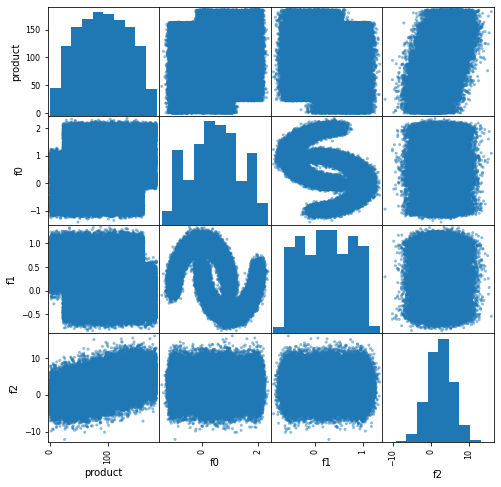

In [15]:
data_0_multi = data_0[['product', 'f0','f1', 'f2']]

print(data_0_multi.corr())
pd.plotting.scatter_matrix(data_0_multi, figsize=(8, 8))
plt.show()

Чем больше сырья в скважине, тем больше показатель f0, f2, и меньше показатель f1. Заметно нормальное распределение продукта и его признаков на гистограммах. Особое внимание стоит уделить зависимости f1 (эта та, что занижается при больших запасах) и f0 (которая при больших запасах растет как будто ступенями).  f1 растёт и пик роста чуть выше максимального значения f0, которое как раз фиксируется под пиком значения f1, затем опускается немного ниже минимального значения f1, где достигает пика спада, затем опять начинает расти. Эти две противоположные параболы очень напоминают галактику. Скорее всего их общий центр - это средний запас продукта, а края - малое и большое значения продукта. А если смотреть зависимость этих показателей от продука, то можно увидеть пороги. 


***Сделаем сводную таблицу, чтобы просмотреть распределение признаков по запасу сырья:***

На графике зависимости f1 и f0 особенно заметна ступенчатость. 
Значит проще определить границы категорий: до 25 мало, от 160 много.


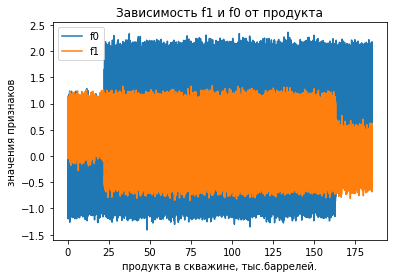

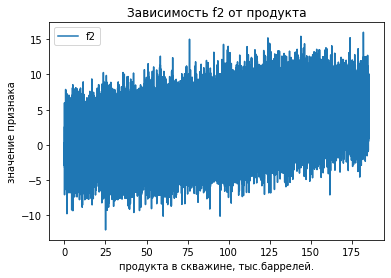

In [16]:
#Построим график зависимости признаков от продукта:
data_0_pivot_p = data_0.pivot_table(index='product', values=['f0','f1'])
data_0_pivot_p.plot()
plt.title('Зависимость f1 и f0 от продукта')
plt.ylabel('значения признаков')
plt.xlabel('продукта в скважине, тыс.баррелей.')

print('На графике зависимости f1 и f0 особенно заметна ступенчатость. \nЗначит проще определить границы категорий: до 25 мало, от 160 много.')

data_0_pivot_f2 = data_0.pivot_table(index='product', values=['f2'])
data_0_pivot_f2.plot()
plt.title('Зависимость f2 от продукта')
plt.ylabel('значение признака')
plt.xlabel('продукта в скважине, тыс.баррелей.')
plt.show()


**Категоризируем данные:**

Для столбца *'product'* поделим значения на категории: vного, средне, мало, - исходя из нашей матрицы корреляции и увиденных "порогов" и нормального распределения на гистограмме.

Напишем функцию для строки:

In [17]:
def product_category(row):
    if row['product'] >= 160:
        return 'много'
    elif 100 > row['product'] >= 25:
        return 'средне'
    else:
        return 'мало'

data_0['product_category'] = data_0.apply(product_category, axis=1)
data_1['product_category'] = data_1.apply(product_category, axis=1)
data_2['product_category'] = data_2.apply(product_category, axis=1)
print('\nНовая таблица:')
data_0.head()


Новая таблица:


,id,f0,f1,f2,product,product_category
0,txEyH,0.705745,-0.497823,1.221170,105.280062,мало
1,2acmU,1.334711,-0.340164,4.365080,73.037750,средне
2,409Wp,1.022732,0.151990,1.419926,85.265647,средне
3,iJLyR,-0.032172,0.139033,2.978566,168.620776,много
4,Xdl7t,1.988431,0.155413,4.751769,154.036647,мало


In [18]:
print('В data_0 запасов сырья:')
data_0.product_category.value_counts()

В data_0 запасов сырья:


средне    49314
мало      44974
много      5712
Name: product_category, dtype: int64

In [19]:
print('В data_1 запасов сырья:')
data_1.product_category.value_counts()

В data_1 запасов сырья:


средне    50387
мало      49613
Name: product_category, dtype: int64

In [20]:
print('В data_2 запасов сырья:')
data_2.product_category.value_counts()

В data_2 запасов сырья:


средне    47794
мало      44771
много      7435
Name: product_category, dtype: int64

В основном запасов сырья средне или мало, много сырья встречается не часто.

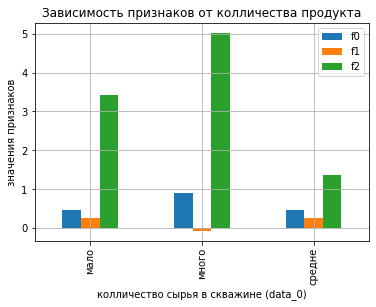

In [21]:
#Посмотрим зависимость признаков от кол-ва продукта:
data_0_pivot_pc = data_0.pivot_table(index='product_category', values=['f0','f1', 'f2'])
data_0_pivot_pc.plot.bar(grid=True)
plt.title('Зависимость признаков от колличества продукта')
plt.ylabel('значения признаков')
plt.xlabel('колличество сырья в скважине (data_0)')
plt.show()

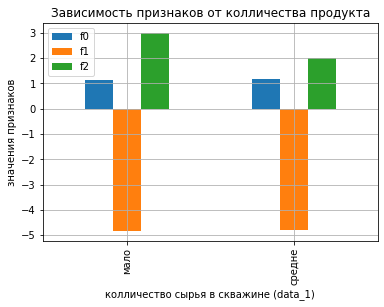

In [22]:
#Посмотрим зависимость признаков от кол-ва продукта:
data_1_pivot_pc = data_1.pivot_table(index='product_category', values=['f0','f1', 'f2'])
data_1_pivot_pc.plot.bar(grid=True)
plt.title('Зависимость признаков от колличества продукта')
plt.ylabel('значения признаков')
plt.xlabel('колличество сырья в скважине (data_1)')
plt.show()

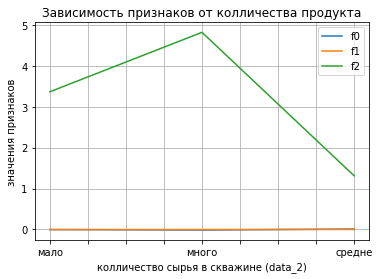

In [23]:
#Посмотрим зависимость признаков от кол-ва продукта:
data_2_pivot_pc = data_2.pivot_table(index='product_category', values=['f0','f1', 'f2'])
data_2_pivot_pc.plot(grid=True)
plt.title('Зависимость признаков от колличества продукта')
plt.ylabel('значения признаков')
plt.xlabel('колличество сырья в скважине (data_2)')
plt.show()

In [24]:
data_2.describe() #просмотрим максимальные, минимальные и седние значения признаков

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


*В регионе data_2 настолько низкие показатели f0 и f1, что пришлось сделать линейный график, чтобы их визуализировать. Эти признаки граничат с нулевой отметкой, при чём независимо от f2. Какой-то странный регион.*

Чем больше сырья в скважине, тем больше показатель *f0*, *f2*, а показатель *f1* ниже. Чем меньше сырья в скважине, тем *f0*, *f2* ниже, а показатель *f1* выше.

**Удалим столбец с категориями для дальнейших рассчётов**

In [25]:
data_0 = data_0.drop('product_category', axis=1)
data_1 = data_1.drop('product_category', axis=1)
data_2 = data_2.drop('product_category', axis=1)
data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


### Вывод 

Мы импортировали все необходимые для работы с данными библиотеки, прочитали таблицы и выяснили, что все 3 таблицы имеюь одинаковое колличество строк и столбцов (1000, 5), а так же типы данных (*object* и *float64*).

## Обучение и проверка модели

***Обучим и проверим модель для каждого региона:***

###  Разобьём данные на обучающую и валидационную выборки в соотношении 75:25 и определим цели и признаки

***Удалим столбец не имеющий значимости для всех регионов:***

In [26]:
data_0 = data_0.drop('id', axis=1)
data_1 = data_1.drop('id', axis=1)
data_2 = data_2.drop('id', axis=1)

#### Регион 1 (data_0)

Сделаем обучающую и валидационную выборки:

In [27]:
data_0_train, data_0_valid = train_test_split(data_0, test_size=0.25, random_state=12345) 

**Определим цели и признаки:**

напишем функцию:

In [28]:
#признаки
def features(data):
    features = data.drop('product', axis=1)
    return features
#цели
def target(data):
    target = data['product']
    return target


Тренировочная выборка (data_0_train, features_0_train, target_0_train):

In [29]:
features_0_train = features(data_0_train)
print('\nПризнаки:')
features_0_train.head(1)


Признаки:


,f0,f1,f2
27212,0.02245,0.951034,2.197333


In [30]:
target_0_train = target(data_0_train)
print('\nЦели:')
display(target_0_train.describe()) 
data_0_train.shape #проверка выборки


Цели:


count    75000.000000
mean        92.640468
std         44.288688
min          0.000000
25%         56.652603
50%         92.131131
75%        128.719821
max        185.364347
Name: product, dtype: float64

(75000, 4)

Валидационная выборка (data_0_valid, features_0_valid, target_0_valid):

In [31]:
features_0_valid = features(data_0_valid)
print('\nПризнаки:')
display(features_0_valid.head(1))
target_0_valid = target(data_0_valid)
print('\nЦели:')
display(target_0_valid.describe())
data_0_valid.shape #проверка выборки


Признаки:


,f0,f1,f2
71751,0.94897,-0.057547,2.095727



Цели:


count    25000.000000
mean        92.078597
std         44.286913
min          0.004022
25%         56.059494
50%         90.897664
75%        128.160698
max        185.315412
Name: product, dtype: float64

(25000, 4)

Соотношение тренировочной выборки к валидационной 75:25.

**Масштабируем признаки:**

*Воспользуемся методом StandardScaler()*

In [32]:
numeric = ['f0', 'f1', 'f2'] #определим признаки в отдельный список

scaler = StandardScaler()

In [33]:
scaler.fit(features_0_train[numeric]) 

features_0_train[numeric] = scaler.transform(features_0_train[numeric])
features_0_valid[numeric] = scaler.transform(features_0_valid[numeric])

#### Регион 2 (data_1)

Сделаем обучающую и валидационную выборки:

In [34]:
data_1_train, data_1_valid = train_test_split(data_1, test_size=0.25, random_state=12345) 

**Определим цели и признаки:**

Тренировочная выборка (data_1_train, features_1_train, target_1_train):

In [35]:
features_1_train = features(data_1_train)
target_1_train = target(data_1_train)

Валидационная выборка (data_1_valid, features_1_valid, target_1_valid):

In [36]:
features_1_valid = features(data_1_valid)
target_1_valid = target(data_1_valid)

**Масштабируем признаки:**

In [37]:
scaler.fit(features_1_train[numeric]) 

features_1_train[numeric] = scaler.transform(features_1_train[numeric])
features_1_valid[numeric] = scaler.transform(features_1_valid[numeric])

#### Регион 3 (data_2)

Сделаем обучающую и валидационную выборки:

In [38]:
data_2_train, data_2_valid = train_test_split(data_2, test_size=0.25, random_state=12345) 

**Определим цели и признаки:**

Тренировочная выборка (data_2_train, features_2_train, target_2_train):

In [39]:
features_2_train = features(data_2_train)
target_2_train = target(data_2_train)

Валидационная выборка (data_2_valid, features_2_valid, target_2_valid):

In [40]:
features_2_valid = features(data_2_valid)
target_2_valid = target(data_2_valid)

Соотношение тренировочной выборки к валидационной 75:25.

**Масштабируем признаки:**

In [41]:
scaler.fit(features_2_train[numeric]) 

features_2_train[numeric] = scaler.transform(features_2_train[numeric])
features_2_valid[numeric] = scaler.transform(features_2_valid[numeric])

#### Проверим получившиеся признаки в выборках всех трёх точек

In [42]:
print('тренировочная выборка региона data_0:')
display(features_0_train.sample(n=2, random_state=1))
print('валидационная выборка региона data_0:')
display(features_0_valid.sample(random_state=1))
print('тренировочная выборка региона data_1:')
display(features_1_train.sample(random_state=1))
print('валидационная выборка региона data_1:')
display(features_1_valid.sample(random_state=1))
print('тренировочная выборка региона data_2:')
display(features_2_train.sample(random_state=1))
print('валидационная выборка региона data_2:')
features_2_valid.sample()

тренировочная выборка региона data_0:


,f0,f1,f2
3002,1.154146,-1.204066,0.247118
16346,-0.512959,1.493984,0.423669


валидационная выборка региона data_0:


,f0,f1,f2
19602,-0.133557,-0.990213,0.050576


тренировочная выборка региона data_1:


,f0,f1,f2
3002,0.580988,-0.562024,0.884801


валидационная выборка региона data_1:


,f0,f1,f2
19602,0.523551,-0.164872,-0.879411


тренировочная выборка региона data_2:


,f0,f1,f2
3002,-1.75293,-0.132357,-0.642571


валидационная выборка региона data_2:


,f0,f1,f2
42289,-0.994851,-0.28349,-0.017467


Везде только нужные нам признаки.

### Обучим модель и сделаем предсказания на валидационной выборке.

*В данном проекте мы будем работать только с моделью линейной регрессии, т.к. остальные модели недостаточно предсказуемые.*

#### Создадим модель линейной регрессии

In [43]:
model = LinearRegression()

Мы создали модель линейной регрессии.

#### Обучим модель на выборках с трёх регионов и узнаем предсказания средних запасов сырья нашей моделью и среднюю квадратичную ошибку нащей модели

**Регион 1 (data_0):**

In [44]:
model.fit(features_0_train, target_0_train)

LinearRegression()

Получим предсказания модели на валидационной выборке.

In [45]:
predictions_0_valid = model.predict(features_0_valid) #Получим предсказания модели
mean_0 = predictions_0_valid.mean() #Рассчитаем средний запас сырья
result_0 = mean_squared_error(target_0_valid, predictions_0_valid)**0.5 #Рассчитаем RMSE
print('Cредний запас предсказанного сырья:', mean_0, 'тыс. баррелей.')
print('RMSE для Региона 1 (data_0):', result_0)

Cредний запас предсказанного сырья: 92.59256778438038 тыс. баррелей.
RMSE для Региона 1 (data_0): 37.5794217150813


Повторим эти процедуры с двумя следующими регионами:

**Регион 2 (data_1):**

In [46]:
model.fit(features_1_train, target_1_train)

LinearRegression()

In [47]:
model.fit(features_1_train, target_1_train)
predictions_1_valid = model.predict(features_1_valid)
mean_1 = predictions_1_valid.mean()
result_1 = mean_squared_error(target_1_valid, predictions_1_valid)**0.5 
print('Cредний запас предсказанного сырья:', mean_1, 'тыс. баррелей.')
print('RMSE для Региона 2 (data_1):', result_1)

Cредний запас предсказанного сырья: 68.728546895446 тыс. баррелей.
RMSE для Региона 2 (data_1): 0.8930992867756159


**Регион 3 (data_2):**

In [48]:
model.fit(features_2_train, target_2_train)

LinearRegression()

In [49]:
model.fit(features_2_train, target_2_train)
predictions_2_valid = model.predict(features_2_valid)
mean_2 = predictions_2_valid.mean()
result_2 = mean_squared_error(target_2_valid, predictions_2_valid)**0.5 
print('Cредний запас предсказанного сырья:', mean_2, 'тыс. баррелей.')
print('RMSE для Региона 3 (data_2):', result_2)

Cредний запас предсказанного сырья: 94.96504596800489 тыс. баррелей.
RMSE для Региона 3 (data_2): 40.02970873393434


Видно, что второй регион отстаёт по запасам нефти, но RMSE минимальный 0.89, в отличие от RMSE третьего региона, которое достигло почти 40.

### Проанализируем результаты

#### Построим график средних запасов предсказанного сырья по регионам:

**Создадим общую для 3-х регионов таблицу:**

Сначала создадим столбцы по имеющимся данным методом `pd.Series()`:

In [50]:
regions = pd.Series(['data_0', 'data_1', 'data_2']) #названия регионов
means = pd.Series(np.array([mean_0, mean_1, mean_2])) #средний запас предсказанного сырья
results = pd.Series(np.array([result_0, result_1, result_2])) #RMSE


Объединим Series в таблицу методом `pd.DataFrame()`:

In [51]:
data = pd.DataFrame({'регионы':regions.values, 'средний запас сырья':means.values, 'RMSE':results.values})
data

,регионы,средний запас сырья,RMSE
0,data_0,92.592568,37.579422
1,data_1,68.728547,0.893099
2,data_2,94.965046,40.029709


**Построим график запаса сырья по регионам:**

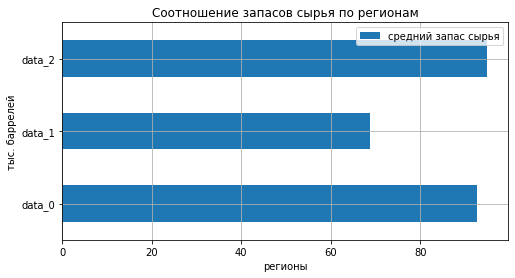

In [52]:
means_pivot = data.pivot_table(index='регионы', values='средний запас сырья')
means_pivot.plot.barh(grid=True, figsize=(8, 4))
plt.ylabel('тыс. баррелей')
plt.xlabel('регионы')
plt.title('Соотношение запасов сырья по регионам')
plt.show()

Примерно одинаковое колличество запасов сырья в регионе 3 (data_2) и регионе 1 (data_0), а вот 2-й регион (data_1) имеет наименьший объём запасов.

**Выведем график RMSE по регионам:**

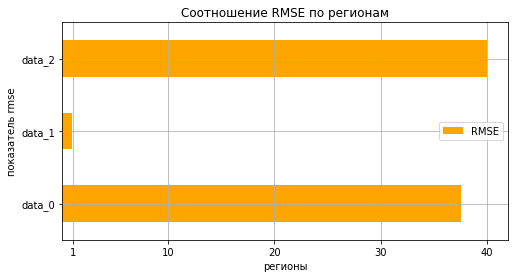

In [53]:
rmse_pivot = data.pivot_table(index='регионы', values='RMSE')
rmse_pivot.plot.barh(color='orange', grid=True, figsize=(8, 4))
plt.ylabel('показатель rmse')
plt.xlabel('регионы')
plt.title('Соотношение RMSE по регионам')
plt.xticks([1, 10, 20, 30, 40])
plt.show()

У data_0 показатель чуть лучше, чем у data_2, а у data_1 этот показатель крайне низкий. Значит наша модель в регионе data_1 довольно точно предсказала запасы сырья.

**Выведем общий график:**

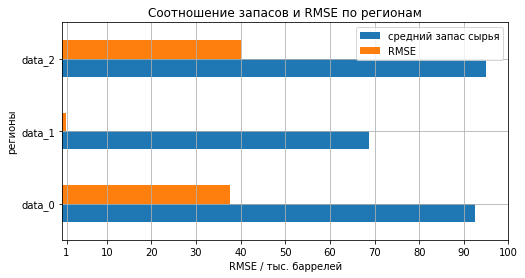

In [54]:

data.plot.barh('регионы', grid=True, figsize=(8, 4))
plt.xlabel('RMSE / тыс. баррелей')
plt.ylabel('регионы')
plt.title('Соотношение запасов и RMSE по регионам')
plt.xticks([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.show()

На графике явно видно, что RMSE у региона data_1 очень маленькая! Хоть и запасов сырья сравнительно меньше, но минимальная ошибка выводит регион в лидеры.

In [55]:
def fit_predict(df):
    train, valid = train_test_split(df, test_size=0.25, random_state=12345) 
    X_train = train.drop('product', axis=1)
    y_train = train['product']
    
    X_valid = valid.drop('product', axis=1)
    y_valid = valid['product']
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_valid = scaler.transform(X_valid)
    
    clf = LinearRegression().fit(X_train,y_train)
    y_pred = clf.predict(X_valid)
    
    print('Cредний запас предсказанного сырья:', y_pred.mean(), 'тыс. баррелей.')
    print('RMSE для Региона:', mean_squared_error(y_valid, y_pred)**0.5)
#     и здесь всякие принты можно поставить
    
    return y_valid.reset_index(drop=True),pd.Series(y_pred)

fit_predict(data_1)

Cредний запас предсказанного сырья: 68.728546895446 тыс. баррелей.
RMSE для Региона: 0.8930992867756159


(0         80.859783
 1         53.906522
 2         30.132364
 3         53.906522
 4          0.000000
             ...    
 24995    137.945408
 24996    110.992147
 24997    137.945408
 24998     84.038886
 24999     53.906522
 Name: product, Length: 25000, dtype: float64,
 0         82.663314
 1         54.431786
 2         29.748760
 3         53.552133
 4          1.243856
             ...    
 24995    136.869211
 24996    110.693465
 24997    137.879341
 24998     83.761966
 24999     53.958466
 Length: 25000, dtype: float64)

### Вывод

В данном разделе мы определили тренировочную и валидационные выборки, обучили модель линейной регрессии на тренировочной выборке и на валидационной выборке поучили предсказания среднего запаса сырья и RMSE по регионам. 

***Лучшим регионом на данный момент является регион 2 (data_1), т.к. у него минимальная RMSE, но стандартный запас сырья.***

## Подготовка к расчёту прибыли

### Все ключевые значения для расчётов сохраним в отдельных переменных. 

#### Ранее мы сохраняли предсказанный средний запас сырья по каждому региону в отдельных переменных:

In [56]:
mean_0 #предсказанный запас в data_0
mean_1 #предсказанный запас в data_1
mean_2 #предсказанный запас в data_2

print('Запасы сырья в регионе data_0:', mean_0)
print('Запасы сырья в регионе data_1:', mean_1)
print('Запасы сырья в регионе data_2:', mean_2)

Запасы сырья в регионе data_0: 92.59256778438038
Запасы сырья в регионе data_1: 68.728546895446
Запасы сырья в регионе data_2: 94.96504596800489


#### Сохраним в отдельных переменных бюджет, цену за 1 тыс. баррелей и максимально допустимую вероятность убытков:

In [57]:
budjet = 10000000000
print('Бюджет на разработку скважин:', budjet, 'рублей.')

Бюджет на разработку скважин: 10000000000 рублей.


In [58]:
barrel_price = 450000
print('Цена за тысячу беррелей:', barrel_price, 'рублей.')

Цена за тысячу беррелей: 450000 рублей.


In [59]:
max_loast = 0.025
print('Максимально допустимая вероятность убытков: {:.1%}'.format(max_loast))

Максимально допустимая вероятность убытков: 2.5%


Рассчитаем бюджет на одну скважину:

In [60]:
budjet_1 = budjet / 200
print('Бюджет на одну скважину', int(budjet_1), 'рублей.')

Бюджет на одну скважину 50000000 рублей.


Рассчитаем минимальное количество продукта:

    Поделим бюджет, выделенный на скважину, на цену за тыс.баррелей продукта.

In [61]:
min_product = budjet_1 / barrel_price 
print('Достаточный объём сырья для безубыточной разработки новой скважины', int(min_product), 'тыс.баррелей')

Достаточный объём сырья для безубыточной разработки новой скважины 111 тыс.баррелей


**Сравним объём сырья для безубыточной разработки новой скважины со средними значениями сырья по регионам:**

Рассчитаем средние запасы сырья по регионам:

In [62]:
mean_product_0 = data_0['product'].mean() #data_0
mean_product_1 = data_1['product'].mean() #data_1
mean_product_2 = data_2['product'].mean() #data_2

In [63]:
print("Cреднее региона data_0:", mean_product_0)
print("Cреднее региона data_1:", mean_product_1)
print("Cреднее региона data_2:", mean_product_2)
print("Достаточный объём сырья для безубыточной разработки новой скважины:", int(min_product))

Cреднее региона data_0: 92.49999999999976
Cреднее региона data_1: 68.82500000002561
Cреднее региона data_2: 95.00000000000041
Достаточный объём сырья для безубыточной разработки новой скважины: 111


Сделаем график для наглядности:

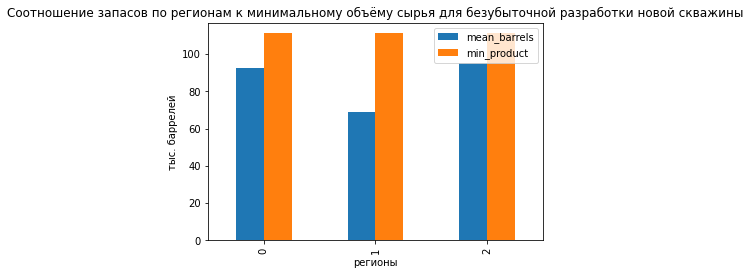

In [64]:
data_means = pd.DataFrame({'data_region':['data_0', 'data_1', 'data_2'], 
                           'mean_barrels': [mean_product_0, mean_product_1, mean_product_2], 
                           'min_product': min_product})
data_means.plot.bar()
plt.ylabel('тыс. баррелей')
plt.xlabel('регионы')
plt.title('Соотношение запасов по регионам к минимальному объёму сырья для безубыточной разработки новой скважины')
plt.show()

По среднему объёму предсказанного сырья в регионах видно, что разработка скважин в регионах будет убыточной. Из этого следует, что точки мы случайно выбирать не можем (тогда разработка скважины просто не окупится) из-за средней низкой концентрации продукта.

#### Сохраним в переменных предсказания и цели валидационной выборки из data_0

Скорректируем таблицу нашего региона, добавив в него предсказанные запасы сырья:

In [65]:
data_0_valid['probabilities'] = predictions_0_valid #добавили столбец с предсказаниями
data_0_valid.head()

,f0,f1,f2,product,probabilities
71751,0.948970,-0.057547,2.095727,10.038645,95.894952
80493,0.992974,0.206671,-0.142278,114.551489,77.572583
2655,1.199854,-0.563356,-1.852991,132.603635,77.892640
53233,0.691422,-0.433347,0.564974,169.072125,90.175134
91141,0.420772,0.972638,0.736190,122.325180,70.510088


Сделаем из предсказаний нашего региона Series:

In [66]:
probabilities_0 = pd.Series(data_0_valid['probabilities']) #вынесли предсказания в отдельный фрейм
probabilities_0.head()

71751    95.894952
80493    77.572583
2655     77.892640
53233    90.175134
91141    70.510088
Name: probabilities, dtype: float64

Сделаем таблицу целей

In [67]:
target_0 = pd.Series(data_0_valid['product'])
target_0.head()

71751     10.038645
80493    114.551489
2655     132.603635
53233    169.072125
91141    122.325180
Name: product, dtype: float64

Все данные для дальнейшего рассчёта прибыли и рисков подготовлены.

#### Добавим в два других региона столбец с предсказаниями:

In [68]:
data_1_valid['probabilities'] = predictions_1_valid
data_2_valid['probabilities'] = predictions_2_valid

**Вынесем предсказания в Series:**

In [69]:
probabilities_1 = pd.Series(data_1_valid['probabilities'])
probabilities_2 = pd.Series(data_2_valid['probabilities'])

**И вынесем столбцы с продуктом в отдельные Series:**

In [70]:
target_1 = pd.Series(data_1_valid['product'])
target_2 = pd.Series(data_2_valid['product'])

#### Напишем функцию для рассчёта прибыли

Напишем функцию для нахождения прибыли со скважин:

    profit = прибыль
    target - цели (сырьё, продукт)
    probabilities - предсказанные моделью запасы сырья
    probs_sorted - отсортированные по убыванию предсказанные запасы сырья
    selected - скважины отсортированных запасов сырья
    budjet - выделенный бюджет на разработку скважин в регионе.
    barrel_price - цена за тысячу баррелей
    count - колличество лучших скважин (по условию проекта их 200)

In [71]:
def profit(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return barrel_price * selected.sum() - budjet

### Вывод

В данном разделе мы сохранили в переменных необходимые для дальнейших рассчётов прибыли и риска данные, а также узнали, что средние предсказанные запасы сырья по регионам (даже в выбранном нами наилучшем регионе) меньше минимального запаса сырья, который будет окупаться. В связи с этим мы не сможем в дальнейшем брать любые случайные 200 скважин (колличество скважин описано в задании проекта) и вычислять на них прибыль, т.к. нам могут попасться скважины с низкой концентрацией сырья. Поэтому нам нужно брать только 200 самых лучших скважин и рассчитывать прибыль именно по лучшим скважинам. Мы написали функцию для рассчёта прибыли.

## Расчёт прибыли и рисков 

Из библиотеки *NumPy* возьмём функцию `RandomState()` что бы находить случайные 500 скважин:

In [72]:
state = np.random.RandomState(12345)

### Рассчитаем среднюю прибыль на валидационной выборке для нашего региона, применив технику *Bootstrap* 

**Напишем функцию для техники Bootstrap:**

**data_0:**

In [73]:
def bootstrap(target, probabilities, r_state):
    values = []
    for i in range(1000):
        target_subsample = target.sample(n=500, replace=True, random_state=r_state)
        probs_subsample = probabilities[target_subsample.index]
        values.append(profit(target_subsample, probs_subsample, 200))
    
    values = pd.Series(values)
    return values

#### Регион 1 (data_0)

In [74]:
values_0 = bootstrap(target_0, probabilities_0, state)
mean_profit_0 = values_0.mean()
print("Средняя прибыль в регионе data_0:", mean_profit_0, 'рублей.')

Средняя прибыль в регионе data_0: 425938526.910592 рублей.


### Рассчитаем убыток на валидационной выборке

Посчитаем колличество убыточных точек (тех, у которых прибыль отрицательная):

**Напишем функцию для определения колличества скважин с отрицательной прибылью:**

In [75]:
def bad_profit_count(values):
    bad_profit_count = 0
    for i in range(len(values)):
        if values[i] < 0:
            bad_profit_count += 1
    return bad_profit_count

#### Регион 1 (data_0)

In [76]:
bad_profit_v0_count = bad_profit_count(values_0)
print('Скважин с отрицательной прибылью:', bad_profit_v0_count)

Скважин с отрицательной прибылью: 60


Теперь найдём процент отрицательной прибыли:

In [77]:
bad_profit_v0 = bad_profit_v0_count / len(values_0) * 100
print('Процент убытка в регионе data_0 на валидационной выборке:',bad_profit_v0, '%')

Процент убытка в регионе data_0 на валидационной выборке: 6.0 %


### Рассчитаем 95%-й доверительный интервал на валидационной выборке

#### Регион 1 (data_0)

In [78]:
confidence_interval = st.t.interval(
    0.95, len(values_0)-1, loc=values_0.mean(), scale=st.sem(values_0))
print("95%-ый доверительный интервал прибыли в регионе data_0:", confidence_interval, 'рублей.')

95%-ый доверительный интервал прибыли в регионе data_0: (408732207.0686983, 443144846.75248575) рублей.


### Рассчитаем те же показатели на валидационных выборках других регионов

#### Регион 2 (data_1)

Прибыль:

In [79]:
values_1 = bootstrap(target_1, probabilities_1, state)
mean_profit_1 = values_1.mean()
print("Средняя прибыль в регионе data_1:", mean_profit_1, 'рублей.')

Средняя прибыль в регионе data_1: 518259493.69732505 рублей.


Доверительный интервал:

In [80]:
confidence_interval_v1 = st.t.interval(
    0.95, len(values_1)-1, loc=values_1.mean(), scale=st.sem(values_1))
print("95%-ый доверительный интервал прибыли в регионе data_1:", confidence_interval_v1, 'рублей.')

95%-ый доверительный интервал прибыли в регионе data_1: (505249881.5766219, 531269105.8180282) рублей.


Риск убытка:

In [81]:
bad_profit_v1_count = bad_profit_count(values_1)
print('Скважин с отрицательной прибылью:', bad_profit_v1_count)

Скважин с отрицательной прибылью: 3


In [82]:
bad_profit_v1 = bad_profit_v1_count / len(values_1) * 100
print('Процент убытка в регионе data_1 на валидационной выборке:', bad_profit_v1, '%')

Процент убытка в регионе data_1 на валидационной выборке: 0.3 %


Прибыль в этом регионе значительно превосходит прошлый регион, риск убытков меньше предельно допустимого, разброс по доверительному интервалу совсем небольшой, наметился лидер среди регионов.

#### Регион 3 (data_2)

Прибыль:

In [83]:
values_2 = bootstrap(target_2, probabilities_2, state)
mean_profit_2 = values_2.mean()
print("Средняя прибыль в регионе data_0:", mean_profit_2, 'рублей.')

Средняя прибыль в регионе data_0: 420194005.34404975 рублей.


Доверительный интервал:

In [84]:
confidence_interval_v2 = st.t.interval(
    0.95, len(values_2)-1, loc=values_2.mean(), scale=st.sem(values_2))
print("95%-ый доверительный интервал прибыли в регионе data_1:", confidence_interval_v2, 'рублей.')

95%-ый доверительный интервал прибыли в регионе data_1: (402528703.6503612, 437859307.0377383) рублей.


Риск убытка:

In [85]:
bad_profit_v2_count = 0
for i in range(len(values_2)):
    if values_2[i] < 0:
        bad_profit_v2_count += 1
print('Скважин с отрицательной прибылью:', bad_profit_v2_count)

Скважин с отрицательной прибылью: 62


In [86]:
bad_profit_v2 = bad_profit_v2_count / len(values_2) * 100
print('Процент убытка в регионе data_1 на валидационной выборке:', bad_profit_v2, '%')

Процент убытка в регионе data_1 на валидационной выборке: 6.2 %


Прибыль в данном регионе больше, чем в data_0, но меньше, чем в data_1, риск убытка превышает максимально допустимые 2,5%.

Сведём в таблицу рассчитаную с тысячи скважин прибыль по регионам и выведем график:

,data_region,прибыль
0,data_0,4.259385e+08
1,data_1,5.182595e+08
2,data_2,4.201940e+08


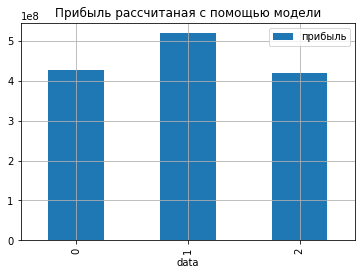

In [87]:
data_profit_1000 = pd.DataFrame({'data_region':['data_0', 'data_1', 'data_2'],
                           'прибыль': [mean_profit_0, mean_profit_1, mean_profit_2]
                                 }
                                )
display(data_profit_1000)
data_profit_1000.plot.bar(grid=True)
plt.xlabel('data')
plt.title('Прибыль рассчитаная с помощью модели')
plt.show()

2-й регион (data_1) приносит больше всего прибыли.

### Проверим наши регионы. Вычислим среднюю прибыль по регионам:

для поиска процента риска с регионов мы будем использовать метод библиотеки *pandas* `query()` .

#### Регион 1 (data_0)

**Рассчитаем среднюю выручку со всего региона data_0:**

Рассчитывать прибыль будем с помощью обычных математических операций над столбцами таблицы данного региона, а затем выведем среднее значение прибыли со всего региона методом `mean()`.

In [88]:
data_0['profit'] = data_0['product'] * barrel_price - budjet / len(data_0)
print('Прибыль с региона data_0:', data_0['profit'].mean(), 'рублей.')

Прибыль с региона data_0: 41524999.999999866 рублей.


**Найдём 95%-й доверительный интервал для всего региона:**

In [89]:
confidence_interval_0 = st.t.interval(
    0.95, len(data_0)-1, loc=data_0['profit'].mean(), scale=st.sem(data_0['profit']))
print("95%-ый доверительный интервал прибыли в регионе data_0:", confidence_interval_0, 'рублей.')

95%-ый доверительный интервал прибыли в регионе data_0: (41401473.90647647, 41648526.093523264) рублей.


Прибыль с региона попадает в доверительный интервал

**Вычислим риск убыточной добычи скважин:**

Исходя из того, что убыток - это отрицательная прибыль, всю прибыль меньше нулевого значения мы посчитаем как остаток, разделим на длину всей таблицы данного региона, а затем умножим на 100, что бы найти процент убытка.

In [90]:
bad_data_0 = data_0.query('profit < 0')
bad_profit_0 = len(bad_data_0) / len(data_0) * 100
print('Процент убытка в регионе data_0:', bad_profit_0, '%')

Процент убытка в регионе data_0: 0.046 %


Чрезмерного убытка в регионе нет.

***Повторим операции с таблицами двух оставшихся регионов:***

#### Регион 2 (data_1)

**Рассчитаем прибыль:**

In [91]:
data_1['profit'] = data_1['product'] * barrel_price - budjet / len(data_1)
print('Прибыль с региона data_1:', data_1['profit'].mean(), 'рублей.')

Прибыль с региона data_1: 30871249.999996234 рублей.


**Найдём 95%-й доверительный интервал для всего региона:**

In [92]:
confidence_interval_1 = st.t.interval(
    0.95, len(data_2)-1, loc=data_1['profit'].mean(), scale=st.sem(data_1['profit']))
print("95%-ый доверительный интервал прибыли в регионе data_0:", confidence_interval_1, 'рублей.')

95%-ый доверительный интервал прибыли в регионе data_0: (30743105.88614409, 30999394.113848377) рублей.


Прибыль с региона попадает в доверительный интервал.

**Найдём вероятность убытка:**

In [93]:
bad_data_1 = data_1.query('profit < 0')
bad_profit_1 = len(bad_data_1) / len(data_1) * 100
print('Риск убытка в регионе data_1:', bad_profit_1, '%')

Риск убытка в регионе data_1: 8.235000000000001 %


Риск убытка в регионе data_1 больше 2,5 %. Данный регион (без работы нашей модели над ним) не подошёл бы для разработки скважин.

#### Регион 3 (data_2)

**Рассчитаем прибыль:**

In [94]:
data_2['profit'] = data_2['product'] * barrel_price - budjet / len(data_2)
print('Прибыль с региона data_2:', data_2['profit'].mean(), 'рублей.')

Прибыль с региона data_2: 42649999.999999925 рублей.


**Найдём 95%-й доверительный интервал для всего региона:**

In [95]:
confidence_interval_2 = st.t.interval(
    0.95, len(data_2)-1, loc=data_2['profit'].mean(), scale=st.sem(data_2['profit']))
print("95%-ый доверительный интервал прибыли в регионе data_0:", confidence_interval_2, 'рублей.')

95%-ый доверительный интервал прибыли в регионе data_0: (42525187.48481299, 42774812.51518686) рублей.


Прибыль с региона попадает в доверительный интервал.

**Найдём риск убытка:**

In [96]:
bad_data_2 = data_2.query('profit < 0')
bad_profit_2 = len(bad_data_2) / len(data_2) * 100
print('Риск убытка в регионе data_2:', bad_profit_2, '%')

Риск убытка в регионе data_2: 0.053 %


У региона маленький риск убытка. Разрабатывать скважины можно.

### Сделаем графики по всем регионам для наглядности

#### Прибыль

,data_region,весь регион,валидационная
0,data_0,4.259385e+08,4.152500e+07
1,data_1,5.182595e+08,3.087125e+07
2,data_2,4.201940e+08,4.265000e+07


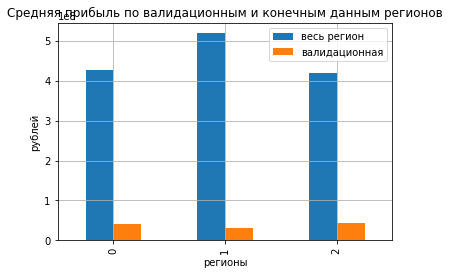

In [97]:
data_profit_valid = pd.DataFrame({'data_region':['data_0', 'data_1', 'data_2'], 
                           'весь регион': [mean_profit_0, mean_profit_1, mean_profit_2], 
                           'валидационная': [data_0['profit'].mean(), data_1['profit'].mean(), data_2['profit'].mean()]
                                 }
                                )
display(data_profit_valid)
data_profit_valid.plot.bar(grid=True)
plt.ylabel('рублей')
plt.xlabel('регионы')
plt.title('Средняя прибыль по валидационным и конечным данным регионов')
plt.show()

Максимальную выручку по валидационным выборкам показывает регион 3 (data_2), вслед за ним идёт регион 1 (data_0). Прибыль по региону 2 (data_1) самая низкая. На полных же таблицах регионов (без вмешательства нашей модели) топ - data_1, за ним data_2, меньше всего приносит прибыли data_0.

#### Убытки

,data_region,весь регион,валидационная
0,data_0,0.046,6.0
1,data_1,8.235,0.3
2,data_2,0.053,6.2


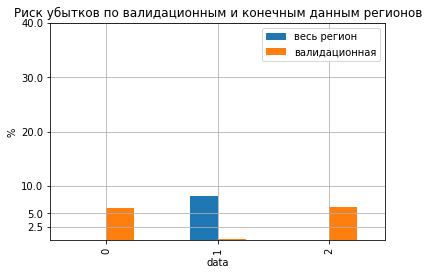

In [98]:
data_profit_valid = pd.DataFrame({'data_region':['data_0', 'data_1', 'data_2'], 
                           'весь регион': [bad_profit_0, bad_profit_1, bad_profit_2], 
                           'валидационная': [bad_profit_v0, bad_profit_v1, bad_profit_v2]
                                 }
                                )
display(data_profit_valid)
data_profit_valid.plot.bar(grid=True)
plt.ylabel('%')
plt.xlabel('data')
plt.title('Риск убытков по валидационным и конечным данным регионов')
plt.yticks([2.5, 5, 10, 20, 30, 40])
plt.show()

Риск убыточной добычи демонстрирует регион 3 (data_2) и у регион 3 (data_2) на валидационных, данных риски крайне велики. Самый низкий риск на валидационной выборке показывает регион 2 (data_1) - он меньше 2,5 %, )  

Однако на полных данных регион 1 и регион 3 не превышают порог в 2,5% и вроде как подходят для разработки скважин. 2-й же регион нам не подходит, т.к. риск убыточной добычи выше 2,5%.

Сравнив эти 2 графика (как бы до и после обучения модели) можно смело говорить о том, что наша модель может предсказать с довольно большой вероятностью наименее убыточный регион для разработки со средним содержанием продукта, хотя на первый взгляд регион кажется убыточным.

### Вывод

В данном пункте мы рассчитали среднюю выручку по регионам, вычислили доверительный интервал по регионам, а также рассчитали риск убытков для рассматриваемых регионов. Мы выяснили, что **самый благоприятный регион** для разработки скважин - это **регион 2 (data_1)** - риск убытков минимальный, прибыль максимальная.

## Общий вывод

Нам была дана задача **найти регион для разработки скважин, который принесёт максимальную прибыль и будет иметь минимальный риск убытков**. Чтобы выполнить эту задачу мы обучили модель линейной регрессии предсказывать объём продукта в регионах. После чего мы использовали полученные моделью данные для поиска самых лучших скважин, что бы по ним рассчитать среднюю прибыль, доверительный интервал и риск убытков. Также мы вычислили эти же параметры на полных таблицах регионов. 

**Самым лучшим** регионом для разработки оказался **регион 2 (data_1)**: прибыль оказалась максимальной, а риск убытков минимальный.

**Исходя из полученных данных регионом для разработки скважин нужно брать регион 2 (data_1), т.к. риски убытков в нём минимальны, а прибыль максимальная.**